In [1]:
import os
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from shapely.affinity import translate
from sklearn.neighbors import NearestNeighbors

# --- Parameters ---
crown_dir = 'input_crowns'
ortho_dir = 'input_om'  # corrected folder name
crown_files = sorted([os.path.join(crown_dir, f)
                     for f in os.listdir(crown_dir) if f.endswith('.gpkg')])
ortho_files = sorted([os.path.join(ortho_dir, f) for f in os.listdir(
    ortho_dir) if f.endswith('.tif')]) if os.path.exists(ortho_dir) else []
print('Crown files found:', crown_files)
print('Ortho files found:', ortho_files)

Crown files found: ['input_crowns/OM1.gpkg', 'input_crowns/OM2.gpkg', 'input_crowns/OM3.gpkg', 'input_crowns/OM4.gpkg', 'input_crowns/OM5.gpkg']
Ortho files found: ['input_om/sit_om1.tif', 'input_om/sit_om2.tif', 'input_om/sit_om3.tif', 'input_om/sit_om4.tif', 'input_om/sit_om5.tif']


In [2]:
# --- Extract and store image patch for each crown from corresponding orthomosaic ---
import rasterio
from rasterio.mask import mask
from shapely.geometry import mapping
import numpy as np
import os
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')


def load_crowns(crown_files, ortho_files):
    crown_images = []  # List of lists: crown_images[om_idx][crown_idx] = image patch
    crowns = []
    for om_idx, (crown_file, ortho_file) in enumerate(zip(crown_files, ortho_files)):
        gdf = gpd.read_file(crown_file)
        crowns.append(gdf)
        if not os.path.exists(ortho_file):
            crown_images.append([None]*len(gdf))
            continue
        with rasterio.open(ortho_file) as src:
            om_images = []
            for i, row in gdf.iterrows():
                geom = [mapping(row['geometry'])]
                try:
                    out_image, out_transform = mask(src, geom, crop=True)
                    # Convert to HWC for visualization
                    img_patch = np.moveaxis(out_image, 0, -1)
                except Exception as e:
                    img_patch = None
                om_images.append(img_patch)
            crown_images.append(om_images)
    return crown_images, crowns


crown_images, crowns = load_crowns(crown_files, ortho_files)
# crown_images[om_idx][crown_idx] is the image patch for that crown

In [3]:
# # --- Display a few example crown image patches extracted from orthomosaics ---
# import matplotlib.pyplot as plt
# num_examples = 2
# examples = []
# for om_idx in range(min(len(crown_images), 5)):
#     for crown_idx in range(min(num_examples, len(crown_images[om_idx]))):
#         img_patch = crown_images[om_idx][crown_idx]
#         if img_patch is not None:
#             examples.append((om_idx+1, crown_idx, img_patch))
# fig, axes = plt.subplots(1, len(examples), figsize=(2*len(examples), 3))
# for i, (om_num, crown_num, img_patch) in enumerate(examples):
#     ax = axes[i]
#     ax.imshow(img_patch)
#     ax.set_title(f'OM{om_num} Crown {crown_num}')
#     ax.axis('off')
# plt.suptitle('Example Crown Image Patches Extracted from Orthomosaics', fontsize=14)
# plt.tight_layout()
# plt.show()

In [4]:
# # Display crowns
# import matplotlib.pyplot as plt
# for i, gdf in enumerate(crowns):
#     fig, ax = plt.subplots(figsize=(10, 10))
#     gdf.boundary.plot(ax=ax, color='red')
#     ax.set_title(f'Crown Polygons - Orthomosaic {i+1}')
#     plt.show()

In [5]:
import os
import geopandas as gpd
import numpy as np
import rasterio
from rasterio.mask import mask
from shapely.geometry import mapping, Polygon
import networkx as nx
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from ipywidgets import Output, VBox, Button
from IPython.display import display, clear_output
import cv2
from scipy.optimize import linear_sum_assignment


class TreeTrackingGraph:
    """
    Tracks tree crowns across multiple orthomosaics using a directed graph (networkx.DiGraph).
    Each node is a tuple (om_id, crown_id) with attributes: geometry, image, and computed crown attributes.
    Each edge stores similarity and other attributes.
    Provides interactive and static visualization methods.
    """

    def __init__(self, crown_dir='input_crowns', ortho_dir='input_om', iou_threshold=0.15, resize_factor=0.1, simplify_tol=1.0, max_crowns=200):
        self.crown_dir = crown_dir
        self.ortho_dir = ortho_dir
        self.iou_threshold = iou_threshold
        self.resize_factor = resize_factor
        self.simplify_tol = simplify_tol
        self.max_crowns = max_crowns
        self.crown_files = sorted([os.path.join(crown_dir, f)
                                  for f in os.listdir(crown_dir) if f.endswith('.gpkg')])
        self.ortho_files = sorted([os.path.join(ortho_dir, f) for f in os.listdir(
            ortho_dir) if f.endswith('.tif')]) if os.path.exists(ortho_dir) else []
        self.G = nx.DiGraph()
        self.om_ids = []
        self.crowns = []
        self.crown_images = []
        self.crown_attributes = []
        self._load_crowns_and_images()

    def _load_crowns_and_images(self):
        """Enhanced loading with attribute computation"""
        self.crown_images = []
        self.crowns = []
        self.crown_attributes = []
        for om_idx, (crown_file, ortho_file) in enumerate(zip(self.crown_files, self.ortho_files)):
            gdf = gpd.read_file(crown_file)
            self.crowns.append(gdf)
            om_attributes = []
            for i, row in gdf.iterrows():
                attrs = self.compute_crown_attributes(row['geometry'])
                attrs['geometry'] = row['geometry']
                om_attributes.append(attrs)
            self.crown_attributes.append(om_attributes)
            if not os.path.exists(ortho_file):
                self.crown_images.append([None]*len(gdf))
                continue
            with rasterio.open(ortho_file) as src:
                om_images = []
                for i, row in gdf.iterrows():
                    geom = [mapping(row['geometry'])]
                    try:
                        out_image, out_transform = mask(src, geom, crop=True)
                        img_patch = np.moveaxis(out_image, 0, -1)
                    except Exception:
                        img_patch = None
                    om_images.append(img_patch)
                self.crown_images.append(om_images)

    def compute_crown_attributes(self, geometry):
        centroid = geometry.centroid
        area = geometry.area
        perimeter = geometry.length
        bounds = geometry.bounds
        compactness = (4 * np.pi * area) / \
            (perimeter ** 2) if perimeter > 0 else 0
        eccentricity = self._compute_eccentricity(geometry)
        aspect_ratio = (bounds[3] - bounds[1]) / (bounds[2] -
                                                  bounds[0]) if bounds[2] != bounds[0] else 1
        return {
            'centroid': centroid,
            'area': area,
            'perimeter': perimeter,
            'compactness': compactness,
            'eccentricity': eccentricity,
            'aspect_ratio': aspect_ratio,
            'bounds': bounds
        }

    def _compute_eccentricity(self, geometry):
        try:
            min_rect = geometry.minimum_rotated_rectangle
            coords = list(min_rect.exterior.coords)
            side1 = np.linalg.norm(np.array(coords[0]) - np.array(coords[1]))
            side2 = np.linalg.norm(np.array(coords[1]) - np.array(coords[2]))
            major_axis = max(side1, side2)
            minor_axis = min(side1, side2)
            return minor_axis / major_axis if major_axis > 0 else 1
        except Exception:
            return 1

    def compute_weighted_similarity(self, attrs1, attrs2, weights=None):
        if weights is None:
            weights = {
                'spatial': 0.4,
                'area': 0.2,
                'shape': 0.2,
                'iou': 0.2
            }
        centroid_dist = attrs1['centroid'].distance(attrs2['centroid'])
        max_dist = 100
        spatial_sim = max(0, 1 - (centroid_dist / max_dist))
        area_ratio = min(attrs1['area'], attrs2['area']) / max(attrs1['area'],
                                                               attrs2['area']) if max(attrs1['area'], attrs2['area']) > 0 else 0
        area_sim = area_ratio
        compactness_sim = 1 - \
            abs(attrs1['compactness'] - attrs2['compactness'])
        eccentricity_sim = 1 - \
            abs(attrs1['eccentricity'] - attrs2['eccentricity'])
        shape_sim = (compactness_sim + eccentricity_sim) / 2
        iou_sim = self.compute_iou(attrs1['geometry'], attrs2['geometry'])
        total_similarity = (
            weights['spatial'] * spatial_sim +
            weights['area'] * area_sim +
            weights['shape'] * shape_sim +
            weights['iou'] * iou_sim
        )
        return total_similarity, {
            'spatial': spatial_sim,
            'area': area_sim,
            'shape': shape_sim,
            'iou': iou_sim,
            'total': total_similarity
        }

    def compute_iou(self, g1, g2):
        intersection = g1.intersection(g2).area
        union = g1.union(g2).area
        return intersection / union if union > 0 else 0

    def process_new_crowns_hungarian(self, om_id, crowns_file, similarity_threshold=0.3):
        gdf = gpd.read_file(crowns_file)
        curr_nodes = []
        curr_attributes = []
        for crown_id, row in gdf.iterrows():
            node = (om_id, crown_id)
            attrs = self.compute_crown_attributes(row['geometry'])
            attrs['geometry'] = row['geometry']
            self.G.add_node(node, **attrs)
            curr_nodes.append(node)
            curr_attributes.append(attrs)
        if not self.om_ids:
            self.om_ids.append(om_id)
            return
        prev_om_id = self.om_ids[-1]
        prev_nodes = [n for n in self.G.nodes if n[0] == prev_om_id]
        prev_attributes = [self.G.nodes[n] for n in prev_nodes]
        if not prev_nodes or not curr_nodes:
            self.om_ids.append(om_id)
            return
        cost_matrix = np.zeros((len(prev_nodes), len(curr_nodes)))
        similarity_matrix = np.zeros((len(prev_nodes), len(curr_nodes)))
        for i, prev_attrs in enumerate(prev_attributes):
            for j, curr_attrs in enumerate(curr_attributes):
                similarity, _ = self.compute_weighted_similarity(
                    prev_attrs, curr_attrs)
                cost_matrix[i, j] = -similarity
                similarity_matrix[i, j] = similarity
        row_indices, col_indices = linear_sum_assignment(cost_matrix)
        matches_added = 0
        for i, j in zip(row_indices, col_indices):
            similarity = similarity_matrix[i, j]
            if similarity >= similarity_threshold:
                prev_node = prev_nodes[i]
                curr_node = curr_nodes[j]
                edge_attrs = {
                    'similarity': similarity,
                    'cost': cost_matrix[i, j],
                    'method': 'hungarian'
                }
                self.G.add_edge(prev_node, curr_node, **edge_attrs)
                matches_added += 1
        self.om_ids.append(om_id)
        print(
            f"Hungarian matching: {matches_added}/{min(len(prev_nodes), len(curr_nodes))} matches above threshold {similarity_threshold}")

    def process_all_hungarian(self):
        for om_idx, (crown_file, ortho_file) in enumerate(zip(self.crown_files, self.ortho_files)):
            print(f"Processing OM {om_idx + 1}...")
            self.process_new_crowns_hungarian(om_idx + 1, crown_file)
            if os.path.exists(ortho_file):
                self._load_images_for_om(om_idx + 1, ortho_file, crown_file)

    def _load_images_for_om(self, om_id, ortho_file, crowns_file):
        gdf = gpd.read_file(crowns_file)
        if not os.path.exists(ortho_file):
            return
        with rasterio.open(ortho_file) as src:
            for crown_id, row in gdf.iterrows():
                node = (om_id, crown_id)
                geom = [mapping(row['geometry'])]
                try:
                    out_image, out_transform = mask(src, geom, crop=True)
                    img_patch = np.moveaxis(out_image, 0, -1)
                except Exception:
                    img_patch = None
                if node in self.G.nodes:
                    self.G.nodes[node]['image'] = img_patch

    def quality_report(self, save_path=None):
        G = self.G
        om_ids = self.om_ids
        metrics = {
            'total_trees_detected': G.number_of_nodes(),
            'total_edges': G.number_of_edges(),
            'total_possible_matches': 0,
            'successful_matches': 0,
            'match_rate_by_om_pair': {},
            'chain_length_distribution': {},
            'average_chain_length': 0,
            'median_chain_length': 0,
            'max_chain_length': 0
        }
        chains = self._extract_all_chains()
        chain_lengths = [len(chain) for chain in chains]
        if chain_lengths:
            metrics['average_chain_length'] = np.mean(chain_lengths)
            metrics['median_chain_length'] = np.median(chain_lengths)
            metrics['max_chain_length'] = max(chain_lengths)
            for length in chain_lengths:
                metrics['chain_length_distribution'][length] = metrics['chain_length_distribution'].get(
                    length, 0) + 1
        for i in range(len(om_ids) - 1):
            om1, om2 = om_ids[i], om_ids[i + 1]
            om1_nodes = [n for n in G.nodes if n[0] == om1]
            om2_nodes = [n for n in G.nodes if n[0] == om2]
            matches = sum(1 for u, v in G.edges()
                          if u[0] == om1 and v[0] == om2)
            possible_matches = min(len(om1_nodes), len(om2_nodes))
            match_rate = matches / possible_matches if possible_matches > 0 else 0
            metrics['match_rate_by_om_pair'][f'{om1}->{om2}'] = {
                'matches': matches,
                'possible': possible_matches,
                'rate': match_rate
            }
            metrics['total_possible_matches'] += possible_matches
            metrics['successful_matches'] += matches
        metrics['overall_match_rate'] = (
            metrics['successful_matches'] /
            metrics['total_possible_matches'] if metrics['total_possible_matches'] > 0 else 0
        )
        report = f"""\n# Tree Tracking Quality Assessment Report\n\n## Overview Statistics\n- **Total Trees Detected**: {metrics['total_trees_detected']}\n- **Total Tracking Edges**: {metrics['total_edges']}\n- **Overall Match Rate**: {metrics['overall_match_rate']:.3f}\n- **Average Chain Length**: {metrics.get('average_chain_length', 0):.2f}\n- **Maximum Chain Length**: {metrics.get('max_chain_length', 0)}\n\n## Match Rates by Orthomosaic Pair\n"""
        for pair, data in metrics['match_rate_by_om_pair'].items():
            report += f"- **{pair}**: {data['matches']}/{data['possible']} ({data['rate']:.3f})\n"
        report += f"""\n## Chain Length Distribution\n"""
        for length, count in sorted(metrics['chain_length_distribution'].items()):
            report += f"- **Length {length}**: {count} trees\n"
        if save_path:
            with open(save_path, 'w') as f:
                f.write(report)
        return report, metrics

    def _extract_all_chains(self):
        visited = set()
        chains = []
        chain_starts = [n for n in self.G.nodes if not list(
            self.G.predecessors(n))]
        for start_node in chain_starts:
            if start_node in visited:
                continue
            chain = self._extract_chain_from_node(start_node)
            chains.append(chain)
            visited.update(chain)
        remaining = set(self.G.nodes) - visited
        for node in remaining:
            chains.append([node])
        return chains

    def _extract_chain_from_node(self, start_node):
        chain = [start_node]
        current = start_node
        while True:
            successors = list(self.G.successors(current))
            if not successors:
                break
            if len(successors) > 1:
                best_successor = max(
                    successors, key=lambda n: self.G[current][n].get('similarity', 0))
                chain.append(best_successor)
                current = best_successor
            else:
                chain.append(successors[0])
                current = successors[0]
        return chain

    def print_graph(self):
        print(
            f"Tracking graph with {self.G.number_of_nodes()} nodes and {self.G.number_of_edges()} edges.")
        for node in self.G.nodes:
            edges = list(self.G.successors(node))
            print(f"Node {node} -> {edges}")

    def show_tracking_stats(self):
        G = self.G
        print(f"Total nodes: {G.number_of_nodes()}")
        print(f"Total edges: {G.number_of_edges()}")
        om_crowns = {}
        for node in G.nodes():
            om_id = node[0]
            om_crowns.setdefault(om_id, 0)
            om_crowns[om_id] += 1
        print("Crowns per OM:")
        for om_id in sorted(om_crowns):
            print(f"  OM {om_id}: {om_crowns[om_id]} crowns")
        print("Matches between consecutive OMs:")
        for i in range(len(self.om_ids)-1):
            om1 = self.om_ids[i]
            om2 = self.om_ids[i+1]
            count = 0
            for u, v in G.edges():
                if u[0] == om1 and v[0] == om2:
                    count += 1
            print(f"  OM {om1} → OM {om2}: {count} matches")

    def get_matching_chain(self, node):
        chain = [node]
        current = node
        while True:
            successors = list(self.G.successors(current))
            if not successors:
                break
            if len(successors) > 1:
                best_successor = max(
                    successors, key=lambda n: self.G[current][n].get('similarity', 0))
                chain.append(best_successor)
                current = best_successor
            else:
                chain.append(successors[0])
                current = successors[0]
        return chain

    def plot_matching_chain(self, chain, highlight_color='orange', normal_color='lightgray'):
        n_oms = len(self.crown_files)
        fig, axes = plt.subplots(2, n_oms, figsize=(4*n_oms, 8))
        for om_idx, crown_file in enumerate(self.crown_files):
            ax_poly = axes[0, om_idx]
            ax_img = axes[1, om_idx]
            gdf = gpd.read_file(crown_file)
            gdf.plot(ax=ax_poly, facecolor='none',
                     edgecolor=normal_color, linewidth=1)
            chain_node = [node for node in chain if node[0] == om_idx+1]
            if chain_node:
                crown_id = chain_node[0][1]
                if crown_id < len(gdf):
                    gdf.iloc[[crown_id]].plot(
                        ax=ax_poly, facecolor='none', edgecolor=highlight_color, linewidth=3)
                node = chain_node[0]
                img_patch = self.G.nodes[node].get('image', None)
                if img_patch is not None:
                    ax_img.imshow(img_patch)
                    ax_img.set_title(f'OM {om_idx+1} Crown {crown_id} Image')
                else:
                    ax_img.set_title(
                        f'OM {om_idx+1} Crown {crown_id}\n(No image)')
            else:
                ax_img.set_title(f'OM {om_idx+1}\n(No tracked crown)')
            ax_poly.set_title(f'OM {om_idx+1}')
            ax_poly.axis('off')
            ax_img.axis('off')
        plt.suptitle(
            'Matching Chain Highlighted Across OMs (Top: polygons, Bottom: images)', fontsize=16)
        plt.tight_layout()
        plt.show()

    def interactive_plot(self):
        if not self.crown_files or not self.ortho_files:
            print("No crown or orthomosaic files found.")
            return
        ortho_path = self.ortho_files[0]
        crown_path = self.crown_files[0]
        with rasterio.open(ortho_path) as src:
            ortho_img = src.read([1, 2, 3])
            ortho_img = np.moveaxis(ortho_img, 0, -1)
            if ortho_img.dtype != np.uint8:
                ortho_img = ((ortho_img - ortho_img.min()) /
                             (ortho_img.ptp()) * 255).astype(np.uint8)
            h, w = ortho_img.shape[:2]
            ortho_img_small = cv2.resize(
                ortho_img, (int(w*self.resize_factor), int(h*self.resize_factor)))
            transform = src.transform
        crowns = gpd.read_file(crown_path)
        fig = go.FigureWidget()
        fig.add_trace(go.Image(z=ortho_img_small))
        for idx, row in crowns.head(self.max_crowns).iterrows():
            if isinstance(row.geometry, Polygon):
                simple_geom = row.geometry.simplify(self.simplify_tol)
                x_geo, y_geo = simple_geom.exterior.xy
                rows, cols = rasterio.transform.rowcol(transform, x_geo, y_geo)
                x_pix = np.array(cols) * self.resize_factor
                y_pix = np.array(rows) * self.resize_factor
                fig.add_trace(go.Scatter(x=x_pix, y=y_pix, mode='lines', name=f'Crown {idx}', customdata=[
                              idx], hoverinfo='name', line=dict(width=2)))
        fig.update_layout(title="Orthomosaic with Clickable Crowns", dragmode='select',
                          height=1200, xaxis=dict(visible=False), yaxis=dict(visible=False))
        out = Output()
        back_btn = Button(description='Back', button_style='info')
        selected_crown = {'idx': None}

        def show_tracking(idx):
            with out:
                clear_output()
                node = (1, idx)
                if node in self.G.nodes:
                    chain = self.get_matching_chain(node)
                    self.plot_matching_chain(chain)
                else:
                    print(f"No tracking data for Crown {idx}.")
                display(back_btn)

        def on_point(trace, points, selector):
            if points.point_inds:
                idx = trace.customdata[0]
                selected_crown['idx'] = idx
                show_tracking(idx)
        for trace in fig.data[1:]:
            trace.on_click(on_point)

        def go_back(btn):
            with out:
                clear_output()
                print("Select a crown polygon to view its tracking.")
        back_btn.on_click(go_back)
        with out:
            print("Select a crown polygon to view its tracking.")
        display(VBox([fig, out]))

Processing OM 1...
Processing OM 2...
Hungarian matching: 80/80 matches above threshold 0.3
Processing OM 3...
Hungarian matching: 116/116 matches above threshold 0.3
Processing OM 4...
Hungarian matching: 130/130 matches above threshold 0.3
Processing OM 5...
Hungarian matching: 150/150 matches above threshold 0.3
Tracking graph with 626 nodes and 476 edges.
Node (1, 0) -> [(2, 89)]
Node (1, 1) -> [(2, 24)]
Node (1, 2) -> [(2, 55)]
Node (1, 3) -> [(2, 26)]
Node (1, 4) -> [(2, 62)]
Node (1, 5) -> [(2, 84)]
Node (1, 6) -> [(2, 34)]
Node (1, 7) -> [(2, 32)]
Node (1, 8) -> [(2, 50)]
Node (1, 9) -> [(2, 88)]
Node (1, 10) -> [(2, 5)]
Node (1, 11) -> [(2, 31)]
Node (1, 12) -> [(2, 81)]
Node (1, 13) -> [(2, 10)]
Node (1, 14) -> [(2, 99)]
Node (1, 15) -> [(2, 27)]
Node (1, 16) -> [(2, 4)]
Node (1, 17) -> [(2, 37)]
Node (1, 18) -> [(2, 33)]
Node (1, 19) -> [(2, 7)]
Node (1, 20) -> [(2, 25)]
Node (1, 21) -> [(2, 23)]
Node (1, 22) -> [(2, 106)]
Node (1, 23) -> [(2, 74)]
Node (1, 24) -> [(2, 68)]


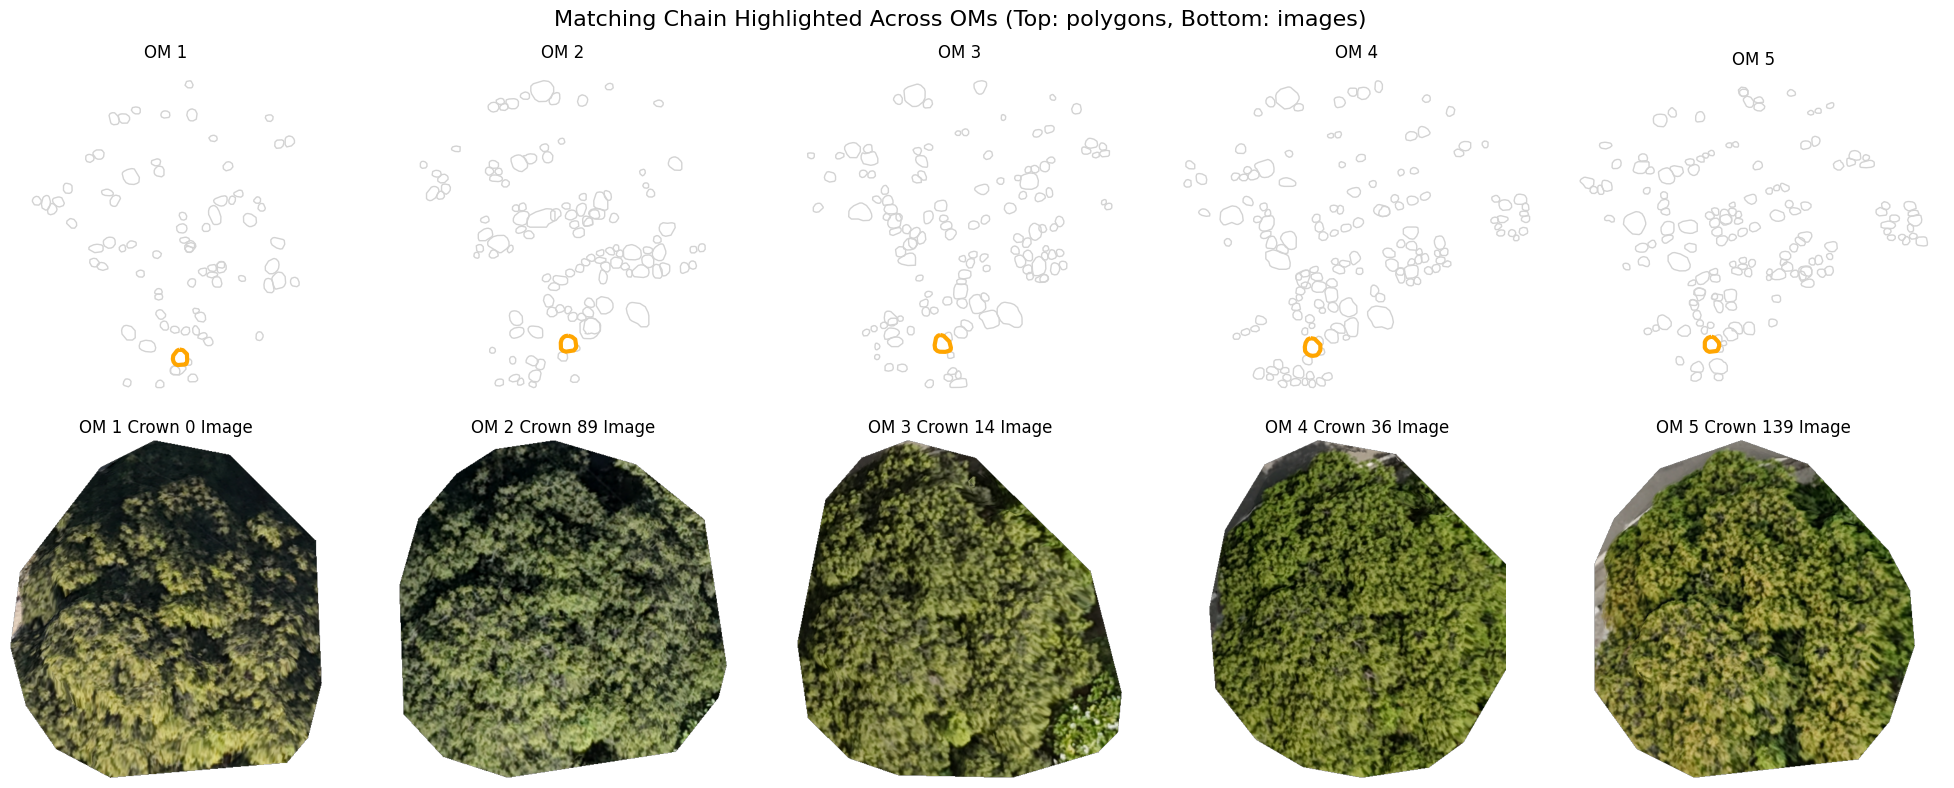

    'data': [{'type': 'image',
              'uid': '868a3642-6a68-4821-b2ea-e60…


# Tree Tracking Quality Assessment Report

## Overview Statistics
- **Total Trees Detected**: 626
- **Total Tracking Edges**: 476
- **Overall Match Rate**: 1.000
- **Average Chain Length**: 4.17
- **Maximum Chain Length**: 5

## Match Rates by Orthomosaic Pair
- **1->2**: 80/80 (1.000)
- **2->3**: 116/116 (1.000)
- **3->4**: 130/130 (1.000)
- **4->5**: 150/150 (1.000)

## Chain Length Distribution
- **Length 2**: 20 trees
- **Length 3**: 14 trees
- **Length 4**: 36 trees
- **Length 5**: 80 trees



In [6]:
# --- Instantiate and use TreeTrackingGraph with Hungarian matching and quality assessment ---
tracking_graph = TreeTrackingGraph(
    crown_dir='input_crowns',
    ortho_dir='input_om',
    iou_threshold=0.15,
    resize_factor=0.1,
    simplify_tol=1.0,
    max_crowns=200
)
tracking_graph.process_all_hungarian()
tracking_graph.print_graph()
tracking_graph.show_tracking_stats()
# Example: visualize matching chain for node (1, 0) if present
example_node = (1, 0)
if example_node in tracking_graph.G.nodes:
    chain = tracking_graph.get_matching_chain(example_node)
    print(f"Matching chain for node {example_node}:")
    for step in chain:
        print(f"  {step}")
    tracking_graph.plot_matching_chain(chain)
else:
    print(f"Node {example_node} not found in graph.")
# Interactive visualization
tracking_graph.interactive_plot()
# Quality assessment report
report, metrics = tracking_graph.quality_report()
print(report)

In [7]:
# # --- Standalone function to visualize matching chains for multiple trees ---
# def visualize_multiple_chains(tracking_graph, node_list, crown_files):
#     for node in node_list:
#         if node in tracking_graph.G.nodes:
#             chain = tracking_graph.get_matching_chain(node)
#             print(f"Matching chain for node {node}:")
#             for step in chain:
#                 print(f"  {step}")
#             tracking_graph.plot_matching_chain(chain, crown_files)
#         else:
#             print(f"Node {node} not found in graph.")

# # Example usage: visualize 5 trees from OM1
# example_nodes = [(1, i) for i in range(20)]
# visualize_multiple_chains(tracking_graph, example_nodes, crown_files)